In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [9]:
df = pd.read_csv('/Users/wonminkim/Projects/DATCapstone/data2/data.csv', index_col=0)
df['Date'] = pd.to_datetime(df['Date'])

# # Forward fill micro, macro, stock
# df[df.columns[1:40]] = df[df.columns[1:40]].ffill()
# # Fill 0 to sentiment
# df[df.columns[40:-5]] = df[df.columns[40:-5]].fillna(0)

df[df.columns[0:-5]] = df.groupby('Ticker')[df.columns[0:-5]].ffill()
df = df.dropna(subset=df.columns[0:-5])

In [10]:
df

,Date,Open,High,Low,Close,Volume,Dividends,Stock Splits,GDP (Billions USD),Unemployment Rate (%),...,emb_763,emb_764,emb_765,emb_766,emb_767,Target_1day,Target_1week,Target_1month,Target_1year,Ticker
43,2021-07-16,273.364810,275.332160,270.835344,272.085541,26186800,0.0,0.0,23921.991,5.4,...,0.842510,-0.409978,0.229860,-0.012287,0.821566,-3.624542,8.644806,11.726654,-23.836212,MSFT
45,2021-07-19,270.321727,271.717289,265.980007,268.460999,32935600,0.0,0.0,23921.991,5.4,...,0.842510,-0.409978,0.229860,-0.012287,0.821566,2.238739,11.668427,17.047180,-17.632233,MSFT
47,2021-07-20,269.449541,272.298810,267.734176,270.699738,26259700,0.0,0.0,23921.991,5.4,...,0.842510,-0.409978,0.229860,-0.012287,0.821566,2.015778,6.997131,13.335327,-22.284302,MSFT
49,2021-07-21,270.292669,272.831807,268.732371,272.715515,24364300,0.0,0.0,23921.991,5.4,...,0.842510,-0.409978,0.229860,-0.012287,0.821566,4.593719,4.671173,9.581451,-19.141220,MSFT
51,2021-07-22,275.080199,277.580592,274.673177,277.309235,23384100,0.0,0.0,23921.991,5.4,...,0.842510,-0.409978,0.229860,-0.012287,0.821566,3.421112,0.348877,10.852570,-21.057861,MSFT
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8095,2025-01-31,236.500000,240.289993,236.410004,237.679993,36162400,0.0,0.0,29723.864,4.0,...,0.242517,-0.188160,-0.536730,-0.404883,0.614863,NaN,NaN,NaN,NaN,AMZN
8096,2025-01-31,218.997334,226.115794,215.647470,220.602478,41151000,0.0,0.0,29723.864,4.0,...,0.939243,-0.054667,-0.330804,-0.237292,0.900818,NaN,NaN,NaN,NaN,AVGO
8097,2025-01-31,201.767628,205.243621,201.567861,203.785309,32042000,0.0,0.0,29723.864,4.0,...,0.707091,-0.305774,-0.334049,-0.197861,0.743848,NaN,NaN,NaN,NaN,GOOGL
8099,2025-01-31,418.141600,419.848170,414.079737,414.229431,34223400,0.0,0.0,29723.864,4.0,...,0.744444,-0.874127,-0.850657,-0.140685,0.215989,NaN,NaN,NaN,NaN,MSFT


In [3]:
# 정렬
df = df.sort_values(by=['Ticker', 'Date']).reset_index(drop=True)

# lag 생성 대상 컬럼과 시차
lag_cols = df.columns[1:40]
lags = [1, 3, 7]

# lag feature를 저장할 리스트
lag_features = []

# lag된 컬럼들 생성
for col in lag_cols:
    for lag in lags:
        lagged = df.groupby('Ticker')[col].shift(lag)
        lag_features.append(lagged.rename(f'{col}_lag{lag}'))

# lag된 컬럼들 DataFrame으로 병합
lag_df = pd.concat(lag_features, axis=1)

# 원본 df와 합치기
df = pd.concat([df.reset_index(drop=True), lag_df.reset_index(drop=True)], axis=1)

# 필요 시 결측치 제거
df = df.dropna().reset_index(drop=True)

In [4]:
from sklearn.decomposition import PCA

# 1. PCA 적용
pca = PCA(n_components=0.95, random_state=42)
emb_cols = [col for col in df.columns if col.startswith("emb_")]
X_emb = df[emb_cols]
X_emb_pca = pca.fit_transform(X_emb)

# 2. PCA 결과를 emb_pca_ 접두사 붙여서 DataFrame으로 변환
pca_columns = [f"emb_pca_{i}" for i in range(X_emb_pca.shape[1])]
df_pca_part = pd.DataFrame(X_emb_pca, columns=pca_columns, index=df.index)

# 3. 원래 데이터에서 emb_ 컬럼 제거
df_non_pca = df.drop(columns=emb_cols)

# 4. 두 DataFrame 합치기
df_pca = pd.concat([df_non_pca.reset_index(drop=True), df_pca_part.reset_index(drop=True)], axis=1)

# 결과 확인
df_pca.head()

,Date,Open,High,Low,Close,Volume,Dividends,Stock Splits,GDP (Billions USD),Unemployment Rate (%),...,emb_pca_92,emb_pca_93,emb_pca_94,emb_pca_95,emb_pca_96,emb_pca_97,emb_pca_98,emb_pca_99,emb_pca_100,emb_pca_101
0,2021-11-02,145.890555,148.746347,145.880732,147.225220,69122000,0.00,0.0,24777.038,4.2,...,-0.187338,-0.148503,0.092599,0.035816,0.060635,0.076168,0.092415,0.067583,0.185425,-0.199745
1,2021-11-03,147.588333,149.138900,147.028959,148.667847,54511500,0.00,0.0,24777.038,4.2,...,-0.187338,-0.148503,0.092599,0.035816,0.060635,0.076168,0.092415,0.067583,0.185425,-0.199745
2,2021-11-04,148.756135,149.590291,147.833644,148.147690,60394600,0.00,0.0,24777.038,4.2,...,-0.187338,-0.148503,0.092599,0.035816,0.060635,0.076168,0.092415,0.067583,0.185425,-0.199745
3,2021-11-05,149.277916,149.582583,147.479385,148.678406,65463900,0.22,0.0,24777.038,4.2,...,-0.187338,-0.148503,0.092599,0.035816,0.060635,0.076168,0.092415,0.067583,0.185425,-0.199745
4,2021-11-08,148.806133,148.963385,147.577630,147.852814,55020900,0.00,0.0,24777.038,4.2,...,-0.187338,-0.148503,0.092599,0.035816,0.060635,0.076168,0.092415,0.067583,0.185425,-0.199745


In [5]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

def random_forest(data, target):
    df = data.copy()
    remove_target_col = [col for col in df.columns if 'Target' in col]
    remove_target_col.remove(target)

    # Drop other Targets and NaNs
    df = df.drop(columns=remove_target_col)
    df = df.dropna(subset=[target])

    # Date processing
    df['Date'] = pd.to_datetime(df['Date'])

    # One-hot encode Ticker
    df = pd.get_dummies(df, columns=['Ticker'], drop_first=True)

    # X, y 분리
    y = df[target]
    X = df.drop(columns=['Date', target])

    # 정규화
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)

    # Train/Test Split
    X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, shuffle=False)

    # 하이퍼파라미터 그리드 설정
    param_grid = {
        'n_estimators': [100, 200],
        'max_depth': [None, 10, 20]
    }

    # GridSearchCV 설정
    grid_search = GridSearchCV(RandomForestRegressor(random_state=42),
                               param_grid,
                               cv=3,
                               scoring='neg_mean_squared_error',
                               n_jobs=-1,
                               verbose=1)

    grid_search.fit(X_train, y_train)
    best_model = grid_search.best_estimator_

    print("Best Parameters:")
    print(grid_search.best_params_)

    # 예측
    y_pred = best_model.predict(X_test)

    # 평가
    mse = mean_squared_error(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)

    print(f"\n Evaluation:")
    print(f"Mean Squared Error (MSE): {mse:.4f}")
    print(f"Mean Absolute Error (MAE): {mae:.4f}")
    print(f"R² Score: {r2:.4f}")

    # 시각화
    test_index = np.arange(len(y_test))
    plt.figure(figsize=(14, 6))
    plt.plot(test_index, y_test.values, label='Actual', linewidth=2)
    plt.plot(test_index, y_pred, label='Predicted', linewidth=2)
    plt.title(f'{target}: Actual vs Predicted')
    plt.xlabel('Test Sample Index')
    plt.ylabel(target)
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

Fitting 3 folds for each of 6 candidates, totalling 18 fits
Best Parameters:
{'max_depth': 10, 'n_estimators': 200}

 Evaluation:
Mean Squared Error (MSE): 32.1574
Mean Absolute Error (MAE): 4.5253
R² Score: -0.1892


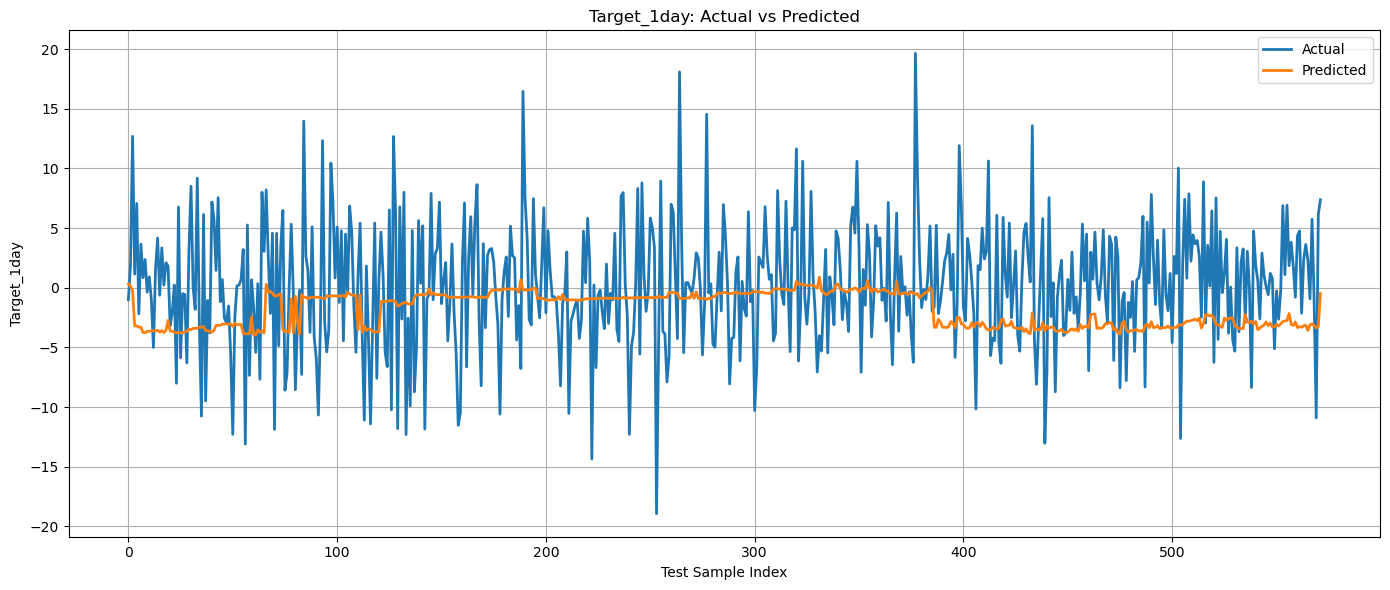

Fitting 3 folds for each of 6 candidates, totalling 18 fits
Best Parameters:
{'max_depth': 10, 'n_estimators': 200}

 Evaluation:
Mean Squared Error (MSE): 102.6916
Mean Absolute Error (MAE): 8.2211
R² Score: 0.0989


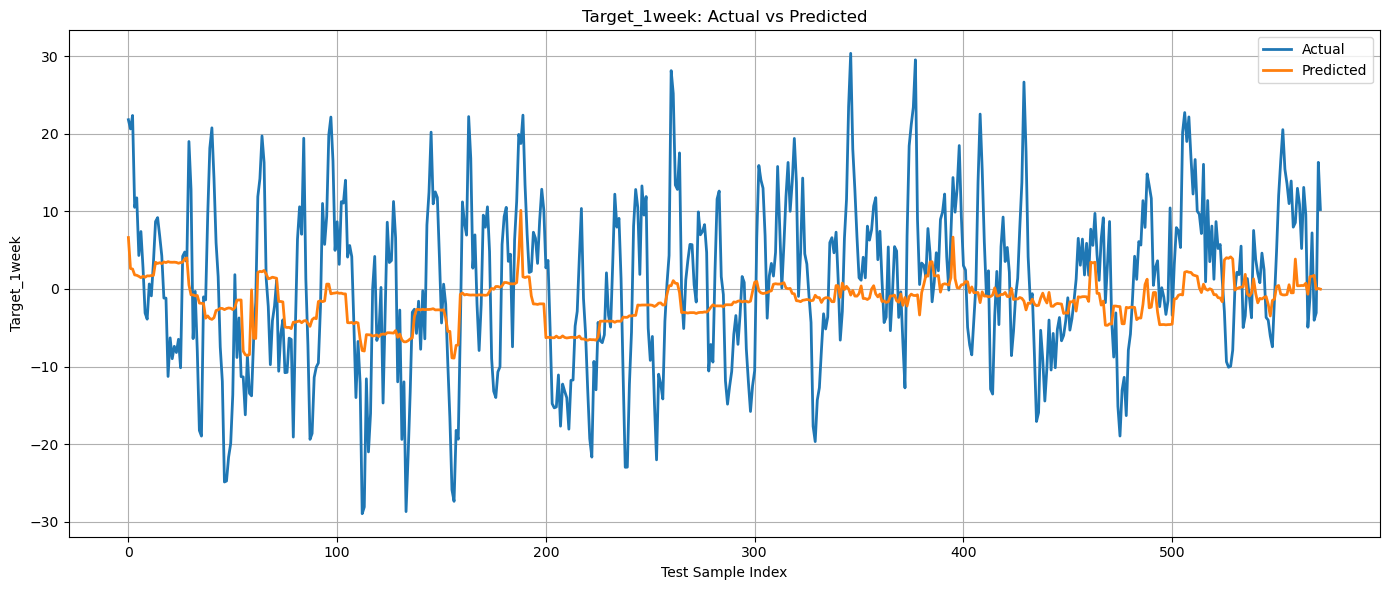

Fitting 3 folds for each of 6 candidates, totalling 18 fits
Best Parameters:
{'max_depth': 10, 'n_estimators': 200}

 Evaluation:
Mean Squared Error (MSE): 332.1647
Mean Absolute Error (MAE): 14.5039
R² Score: 0.1538


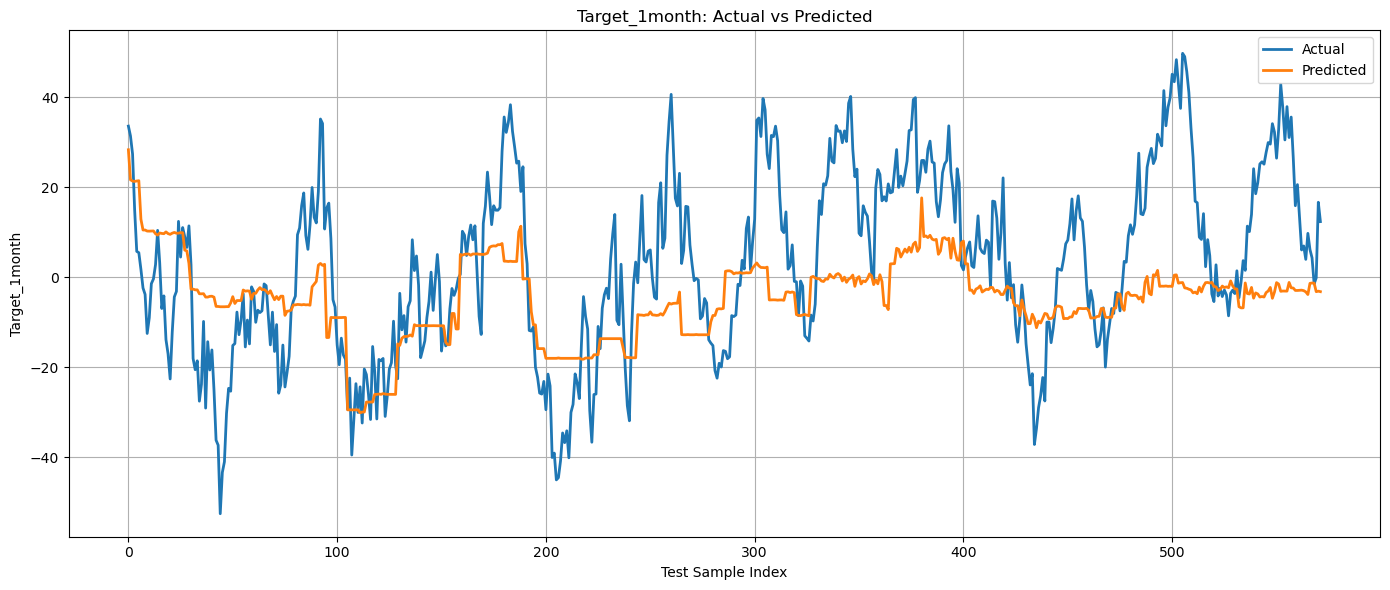

Fitting 3 folds for each of 6 candidates, totalling 18 fits
Best Parameters:
{'max_depth': None, 'n_estimators': 200}

 Evaluation:
Mean Squared Error (MSE): 4196.2219
Mean Absolute Error (MAE): 55.3222
R² Score: 0.1822


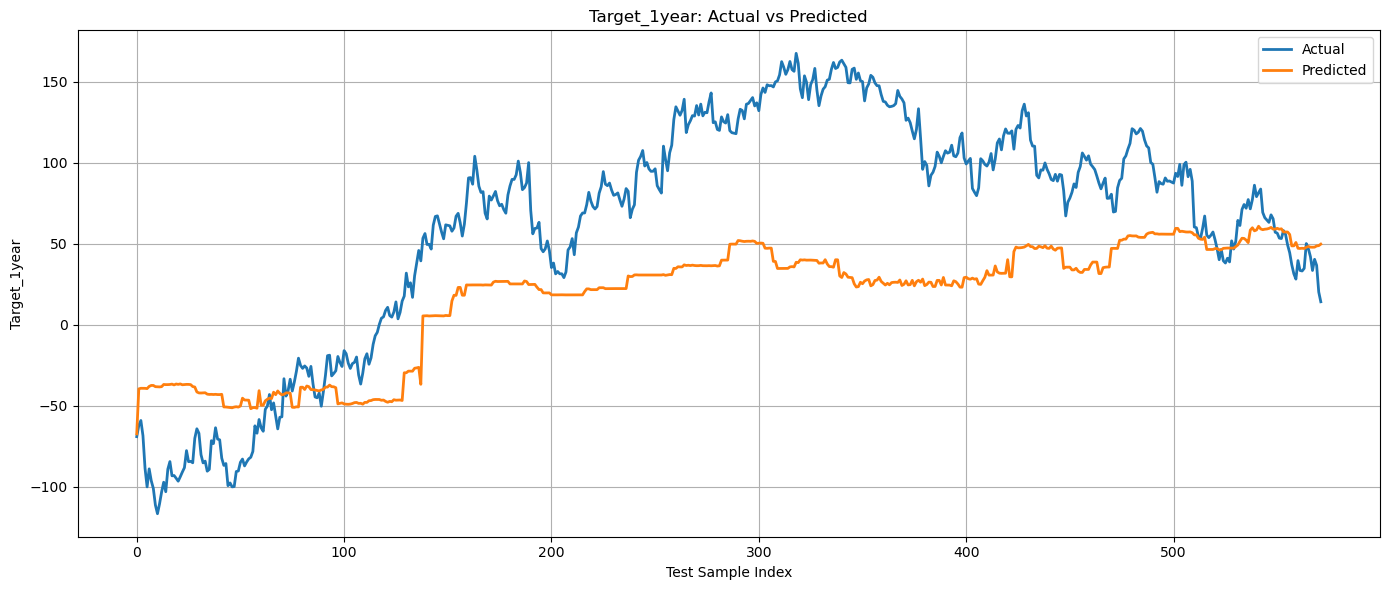

In [6]:
random_forest(df_pca, 'Target_1day')
random_forest(df_pca, 'Target_1week')
random_forest(df_pca, 'Target_1month')
random_forest(df_pca, 'Target_1year')

In [7]:
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.preprocessing import StandardScaler
import lightgbm as lgb

def lightgbm_model(data, target):
    df = data.copy()
    
    # 1. 타겟 처리
    remove_target_col = [col for col in df.columns if 'Target' in col]
    remove_target_col.remove(target)
    df = df.drop(columns=remove_target_col)
    df = df.dropna(subset=[target])

    # 2. 날짜 처리
    df['Date'] = pd.to_datetime(df['Date'])

    # 3. 범주형 처리
    df = pd.get_dummies(df, columns=['Ticker'], drop_first=True)

    # 4. X, y 분리
    y = df[target]
    X = df.drop(columns=['Date', target])

    # 5. 스케일링
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)

    # 6. 데이터 분리
    X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, shuffle=False)

    # 7. 하이퍼파라미터 그리드
    param_grid = {
        'num_leaves': [31, 63],
        'max_depth': [-1, 10, 20],
        'learning_rate': [0.1, 0.01],
        'n_estimators': [100, 200]
    }

    # 8. GridSearchCV
    model = lgb.LGBMRegressor(random_state=42, n_jobs=-1)
    grid_search = GridSearchCV(estimator=model,
                               param_grid=param_grid,
                               cv=3,
                               scoring='neg_mean_squared_error',
                               verbose=0,
                               n_jobs=-1)

    grid_search.fit(X_train, y_train)
    best_model = grid_search.best_estimator_

    print("Best Parameters:")
    print(grid_search.best_params_)

    # 9. 예측
    y_pred = best_model.predict(X_test)

    # 10. 평가
    mse = mean_squared_error(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)

    print(f"\n Evaluation:")
    print(f"Mean Squared Error (MSE): {mse:.4f}")
    print(f"Mean Absolute Error (MAE): {mae:.4f}")
    print(f"R² Score: {r2:.4f}")

    # 11. 시각화
    test_index = np.arange(len(y_test))
    plt.figure(figsize=(14, 6))
    plt.plot(test_index, y_test.values, label='Actual', linewidth=2)
    plt.plot(test_index, y_pred, label='Predicted', linewidth=2)
    plt.title(f'{target}: Actual vs Predicted (LightGBM)')
    plt.xlabel('Test Sample Index')
    plt.ylabel(target)
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004838 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 33487
[LightGBM] [Info] Number of data points in the train set: 1523, number of used features: 252
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.010896 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 33959
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.012184 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.013007 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.012932 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Start tra

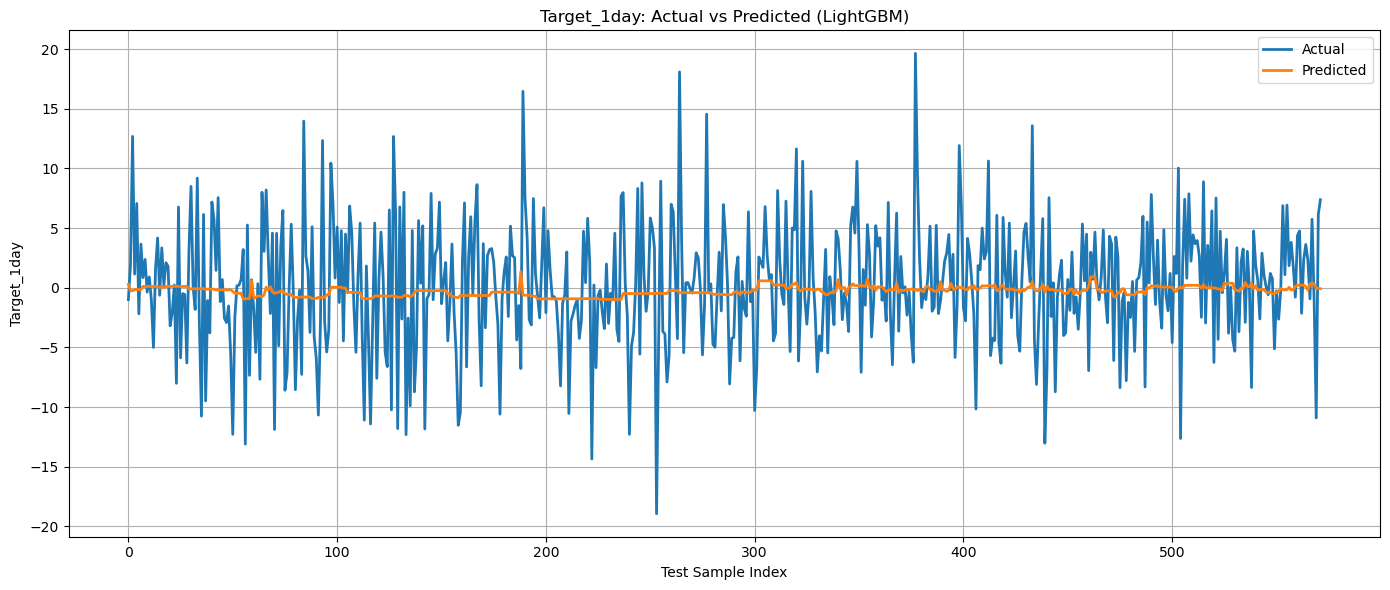

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005359 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 33959
[LightGBM] [Info] Number of data points in the train set: 1523, number of used features: 255
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.020365 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 33331
[LightGBM] [Info] Start training from score 0.372617
[LightGBM] [Info] Number of data points in the train set: 1522, number of used features: 255
[LightGBM] [Info] Start training from score 0.816404
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.036764 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 33331
[LightGBM] [Info] Number of data points in the train set: 1522, number of used features: 255
[LightGBM] [Info] Auto-c

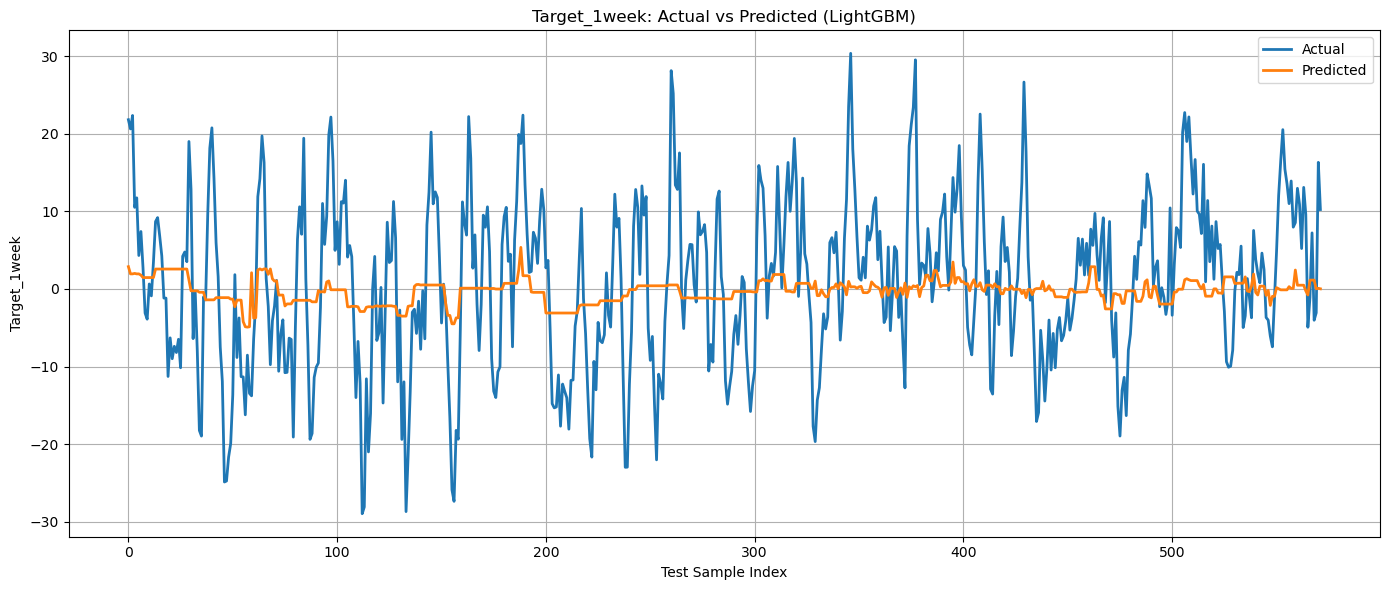

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.009862 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 33487
[LightGBM] [Info] Number of data points in the train set: 1523, number of used features: 252
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.009012 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Start training from score 1.030924
[LightGBM] [Info] Total Bins 33487
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.014566 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 33331
[LightGBM] [Info] Number of data points in the train set: 1523, number of used features: 252
[LightGBM] [Info] Number of data points in

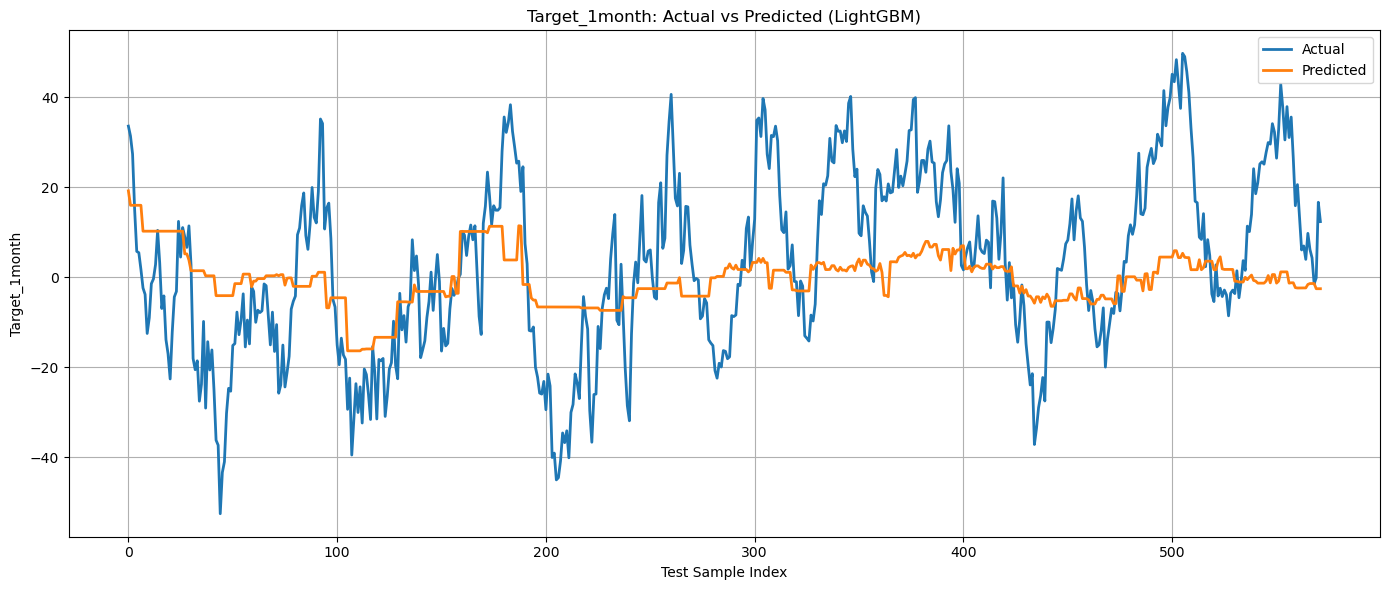

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.022438 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 33487
[LightGBM] [Info] Number of data points in the train set: 1523, number of used features: 252
[LightGBM] [Info] Start training from score 28.338516
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.016783 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 33331
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.019138 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 33959
[LightGBM] [Info] Number of data points in the train set: 1522, number of used features: 255
[LightGBM] [Info] Number of data points in the train set: 1523, number of used features: 255
[LightGBM] [Info] Start training from score 40.517526
[LightGBM] [Info] Star

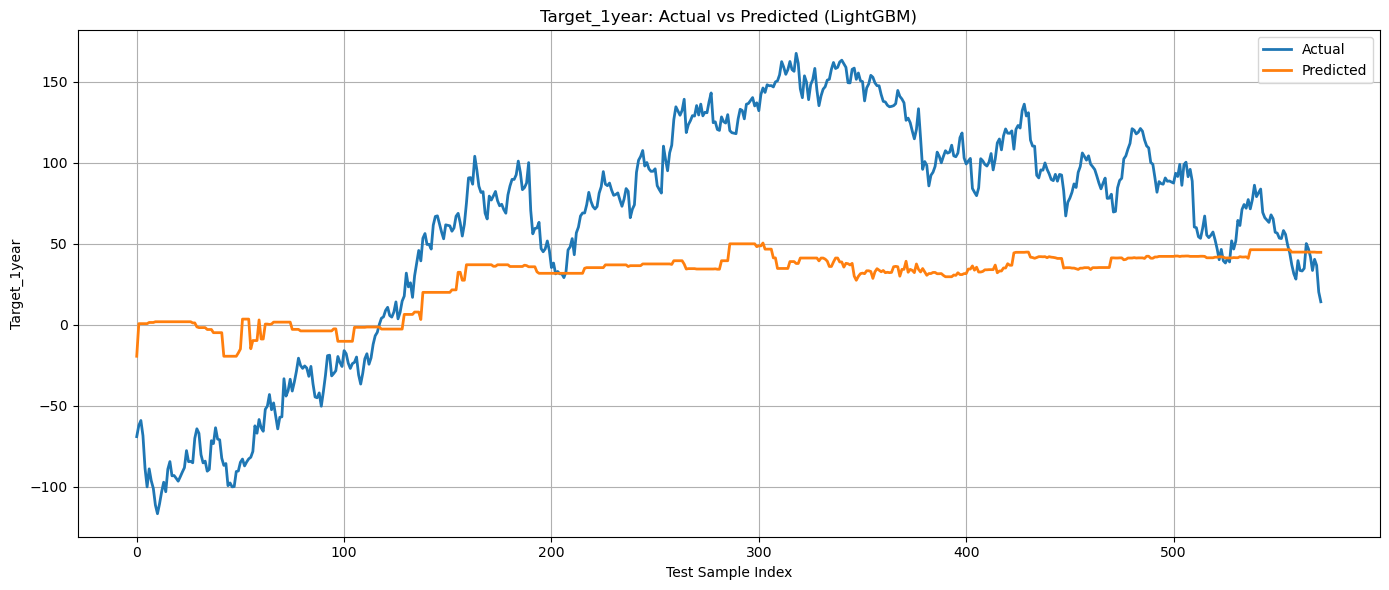

In [8]:
lightgbm_model(df_pca, 'Target_1day')
lightgbm_model(df_pca, 'Target_1week')
lightgbm_model(df_pca, 'Target_1month')
lightgbm_model(df_pca, 'Target_1year')